# Project Description - Parallelized Tools for Point Pattern Analysis
----------------
**Hu Shao**


## General Scope
The main purpose of this project is to develop some parallelized algorithm/tools to leverage the performance of existing point pattern analysis methods in [Pysal](https://github.com/pysal).  
Simulating spatial processes in general is computation intensive. For example, in [Distance Based Statistical Method for Planar Point Patterns](https://github.com/sjsrey/pysal/blob/points_contrib/pysal/contrib/points/distance_statistics.py), we need to simulate CSR or a specific spatial process for a lot of times to build simulation envelops for the hypothesis testing. Parallelizing this process is important and logically straightforward.  
##  Tentative workplan
1. Get familiar with parallel computing algorithm of Python and the point pattern analysis algorithms in Pysal.
2. Develop the parallelized algorithms for Pysal.

## Deliverables
This work will contribute to the [point pattern module](https://github.com/sjsrey/pysal/tree/points_contrib/pysal/contrib/points) of Pysal

## Working Process
------------
The step by step working process will be recorded in this section

### Step 1:
<b style="color:blue">Figure out the computing process for a specific point pattern analysis and decide which parts of them could be parallelized</b>  
Directly related pages for reading:
- pointpattern.ipynb  
    - This page briefly introduces the basic knowledge about point pattern and the implementation of "Point pattern analysis" in PySAL's "pointpattern" module. It also talks about how a point lists can be loaded into this module.  
- distance_statistics.ipynb
    - G function: just calculate the nearest neighbor distance of each event. Say, if there are 12 events, then there will be 12 distances.
    - F function: randomly generate extra points and calculate the distance of nearest event to each of the points. So, the distances' number equals to the number of generated points. If the number of generated points is large (e.g. 100), then the result statistic line will be smoother than the G function.

### Step2:
<b style="color:blue">Get familiar the exactly calculation process form importing point to generating the simulation envelop</b>  
**Importing points into PointPattern Class**  
``
def __init__(self, points, window=None, names=None, coord_names=None):
``
Two parameters are important in the init function:
1. points: all the sample points
2. window: study area/constrain.  
    The window parameter takes instance of the class *pysal.contrib.points.Window*, which is an sub-class of *pysal.cg.shapes.Polygon*  
    The inherit function **contains_point** is used to determine whether a randomly generated point locates in the polygon. Finally the "real" contains_point function is implemented in the class *Ring*. Typical method is used: firstly check if the points located in the BBX of polygon; If yes, compare this point to every line segment of the boundary.

In [1]:
# Import essential libraries for following calculation
import sys
path_base_dell = 'C:/work/ASUWork/pysal'
path_base_lenove = 'D:/ASUWork/pysal'
path_base_os = '/Users/hushao/Documents/ASUWork/pysal/'
sys.path.append(path_base_dell)
sys.path.append(path_base_lenove)
sys.path.append(path_base_os)
import pysal as ps
import numpy as np
from pysal.contrib.points.pointpattern import PointPattern
from pysal.contrib.points.process import PoissonPointProcess 
from pysal.contrib.points.distance_statistics import G, F, J, K, L
from pysal.contrib.points.distance_statistics import Genv, Fenv, Jenv, Kenv, Lenv
%matplotlib inline
import matplotlib.pyplot as plt

from pysal.cg.shapes import Polygon, Point
import time
print("import finished!")

import finished!


In [3]:
time_begin = int(round(time.time() * 1000))
pols = ps.open("data/Tunxi_region.shp")
for polygon in pols:
    print(polygon)
polygon = pols[0]
time_end = int(round(time.time() * 1000))
print(time_begin, time_end, time_end - time_begin)

(1461224116692L, 1461224116694L, 2L)


In [8]:
print("lenght of points in polygon:", len(polygon.vertices))
print(polygon.vertices[0], polygon.vertices[len(polygon.vertices)-1])
print(polygon.vertices[0] == polygon.vertices[len(polygon.vertices)-1])
polygon.contains_point((1,3))

('lenght of points in polygon:', 426)
((118.357163, 29.782866), (118.357163, 29.782866))
True


False

In [30]:
time.time()

1461196569.788

(12, 2)
        x      y
0   66.22  32.54
1   22.52  22.39
2   31.01  81.21
3    9.47  31.02
4   30.78  60.10
5   75.21  58.93
6   79.26   7.68
7    8.23  39.93
8   98.73  77.17
9   89.78  42.53
10  65.19  92.08
11  54.46   8.48


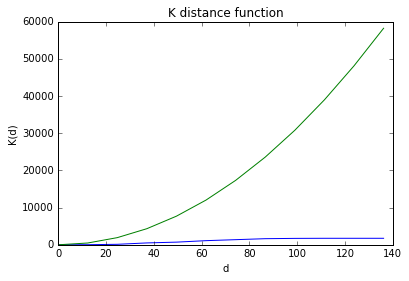

In [15]:
points = [[66.22, 32.54], [22.52, 22.39], [31.01, 81.21],
          [9.47, 31.02],  [30.78, 60.10], [75.21, 58.93],
          [79.26,  7.68], [8.23, 39.93],  [98.73, 77.17],
          [89.78, 42.53], [65.19, 92.08], [54.46, 8.48]]
pp = PointPattern(points) # import the points into the class PointPattern
kf = K(pp) # Calculate the K function for the points
kf.plot()

In [9]:
realizations = PoissonPointProcess(pp.window, pp.n, 100, asPP=True) # simulate CSR 100 times
kenv = Kenv(pp, intervals=20, realizations=realizations)
kenv.plot()

NameError: name 'pp' is not defined

## Algorithm of building quadtree cells for research area
A huge number of points will be simulated and test if falls in the study area in the real case. This calculation process is very computing intensive. Especially when the boundary of study area is complex and contains a lot of segments, or the simulation time is also large.   
In order to fast decide whether a point is contained in the study area, we can prepare an grid structure which divide the study area into quadtree based regular rectangles. Each rectangles will have a specific status from ['in', 'out', 'maybe']. After we prepared this kind of grid structure, deciding whether a points falls in the study area will be very easy: first, allocate the point into a specific cell. For the cell with different status:  
- in: the point must be in the study area  
- out: the point must not be in the study area  
- maybe: decide if the points falls into the study area by some following-up calculation. However, the small polygon contains much less boundary segments, the calculation will be much easier. What's more, this kind of grids only take over a very small part of the whole grids  
![quadtree_example](img/quadtree_example.png)

### Process of duadtree dividing of the study area:
Treat the boundary of the study area as arc. Each time of dividing the study area means use two straight lines (on horizontal and one vertical) to split a big rectangle (cell) into 4 smaller ones. During this process, the arc should also be used to intersect with the straight lines and break into small segments. Different segments should belong to different cells and can be used to determine the status of the cell (as we mentioned: in, out or maybe inside of the study area.) Repeat this process until the cell's size is small enough.  
During the dividing, there are <font style="color:blue">some special properties of the arcs</font> we need to know:  
- Point order of the arcs **MUST** be clockwise  
- The two end-points of each arc **MUST** lie on the borders of the cell  
- When a arc goes in a cell, it **MUST** goes out from the same one  
- The intersection points **MUST** be lying on the inner-boundaries which are used to divide the cell into 4 sub-cells
- Use the intersection points to split the arcs into small ones  
- No need to store cell boundaries as arcs, store the intersection points, points' relative location from  


The following image depicts the categorize rule of cell boundary when being divided into sub cells:  
<b style="color:blue">cell_boundary_category_rule</b>  
![cell_boundary_category_rule](img/cell_boundary_category_rule.png)

<b style="color:blue">segment_sequence_search_rule</b>  
![segment_sequence_search_rule](img/segment_sequence_search_rule.png)

In the situations that there are some arcs intersect with a cell and we need to extract the segment squence, here is the rule:  
1. Start on the bottom-left point of the cell, go clockwise to search points.  
2. Find the first arc-begin-point on the cell's border. The actual segment sequence begin from here.  
3. Go alone the arc until the end point on the border. Then go alone the cell's border until find next arc-begin-point.  
4. Repeat **Step.3** until reach the first arc-begin-point at **Step.2**. Search stop.

From the image we can see that the red border lines also belong to the segment sequence.  
During the quadtree dividing, when there is a cell who doesn't intersect with any arc, we need to determine whether this cell is totally within the study area or not. we Can use the method above to determine: If this cell share a border which belongs to other cells' segment sequence, then this cell is totally within the study area; vice versa

In [2]:
1==1==2

False